<ul class="breadcrumb">
  <li><a href="1.2.Multivariate_Linear_Mixed_Effects_Model.ipynb">Multivariate Basics</a></li>
  <li><a href="2.2.Multivariate_Linear_Additive_Genetic_Model.ipynb">Multivariate Additive Genetic Model</a></li> 
  <li><a href="3.2.Multivariate_Linear_Mixed_Effects_Model_with_Genomic_Data.ipynb">Multivariate Genomic Data</a></li>
</ul>

<div class="span5 alert alert-success">
 <font size="5" face="Georgia">Multivariate Linear Mixed Effects Model with Genomic Data</font> 
</div>

In [1]:
include("../src/JWAS.jl")

JWAS

In [2]:
using DataFrames,JWAS
using JWAS: Datasets,misc

<button type="button" class="btn btn-lg btn-primary">Data</button> 

In [3]:
phenofile = Datasets.dataset("testMT","phenotype.txt")
genofile  = Datasets.dataset("testMT","genotype.txt")
pedfile   = Datasets.dataset("testMT","pedigree.txt");

### phenotypes

In [4]:
;cat $phenofile

Animal,BW,CW,age,sex
S1,100.0,10.0,8,M
D1,50.0,12.9,7,F
O1,150.0,13.0,3,M
O3,40.0,5.0,4,F


### genotypes

In [5]:
;cat $genofile

Animal,x1,x2,x3,x4,x5
S1,1.0,0.0,1.0,1.0,1.0
D1,2.0,0.0,2.0,2.0,1.0
O1,1.0,2.0,0.0,1.0,0.0
O3,0.0,0.0,2.0,1.0,1.0


### pedigree

In [6]:
;cat $pedfile

S1 0 0
D1 0 0
O1 S1 D1
O2 S1 D1
O3 S1 D1


In [7]:
data=readtable(phenofile)

,Animal,BW,CW,age,sex
1,S1,100.0,10.0,8,M
2,D1,50.0,12.9,7,F
3,O1,150.0,13.0,3,M
4,O3,40.0,5.0,4,F


<div class="span5 alert alert-info">
 <font size="5" face="Georgia">I. Multiple Traits Analyses with Marker Information</font><br> 
</div>

<button type="button" class="btn btn-lg btn-primary">Build Model</button> 

### Genetic covariance matrix and residual covariance matrix

In [15]:
R      = [10.0 2.0
           2.0 1.0]
G      = [20.0 1.0
           1.0 2.0];

In [16]:
model_equations = "BW = intercept + age + sex;
                   CW = intercept + age + sex";

In [17]:
model1 = build_model(model_equations,R);

In [18]:
set_covariate(model1,"age");

In [19]:
add_markers(model1,genofile,G,separator=',',header=true);

5 markers on 4 individuals were added.


<button type="button" class="btn btn-lg btn-primary">Run Model</button> 

In [20]:
Pi=Dict([1.0; 1.0]=>0.7,[1.0;0.0]=>0.1,[0.0,1.0]=>0.1,[0.0; 0.0]=>0.1)
out = runMCMC(model1,data,Pi=Pi,chain_length=5000,methods="BayesC",
estimatePi=true,output_samples_frequency=5);

Priors for marker effects covariance matrix were calculated from genetic covariance matrix and π.
Marker effects covariance matrix is 
[10.958904 0.626223
 0.626223 1.09589].


MCMC Information:
methods                                      BayesC
chain_length                                   5000
estimatePi                                     true
constraint                                    false
missing_phenotypes                            false
starting_value                                false
output_samples_frequency                          5
printout_frequency                             5001
update_priors_frequency                           0

Degree of freedom for hyper-parameters:
residual variances:                           4.000
iid random effect variances:                  4.000
polygenic effect variances:                   4.000
marker effect variances:                      4.000



running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:01


<button type="button" class="btn btn-lg btn-primary">Check Results</button> 

In [21]:
keys(out)

Base.KeyIterator for a Dict{Any,Any} with 7 entries. Keys:
  "Model frequency"
  "Posterior mean of residual covariance matrix"
  "Posterior mean of marker effects"
  "Posterior mean of marker effects covariance matrix"
  "MCMC samples for residual covariance matrix"
  "Posterior mean of location parameters"
  "Posterior mean of Pi"

In [22]:
file1="MCMC_samples_for_marker_effects_BW.txt"
file2="MCMC_samples_for_marker_effects_CW.txt";

In [23]:
get_breeding_values(model1,file1,file2)

2-element Array{Any,1}:
 4×3 DataFrames.DataFrame
│ Row │ ID   │ EBV      │ PEV     │
├─────┼──────┼──────────┼─────────┤
│ 1   │ "S1" │ -1.13724 │ 8.07753 │
│ 2   │ "D1" │ 8.04833  │ 86.4629 │
│ 3   │ "O1" │ 3.37534  │ 70.1204 │
│ 4   │ "O3" │ -10.2864 │ 70.7876 │            
 4×3 DataFrames.DataFrame
│ Row │ ID   │ EBV       │ PEV      │
├─────┼──────┼───────────┼──────────┤
│ 1   │ "S1" │ -0.137831 │ 0.538611 │
│ 2   │ "D1" │ 2.29012   │ 6.84982  │
│ 3   │ "O1" │ 0.163889  │ 4.43166  │
│ 4   │ "O3" │ -2.31618  │ 4.63616  │

In [24]:
samples4G=get_additive_genetic_variances(model1,file1,file2);

In [25]:
samples4R=out["MCMC samples for residual covariance matrix"];

In [26]:
samples4h2=get_heritability(reformat(samples4G),reformat(samples4R));

In [27]:
samples_genetic_correlation=get_correlations(reformat(samples4G));

Summary Stats:
Mean:         0.543587
Minimum:      0.000000
1st Quartile: 0.071374
Median:       0.723365
3rd Quartile: 0.951360
Maximum:      0.994886
nothing
[Plots.jl] Initializing backend: pyplot



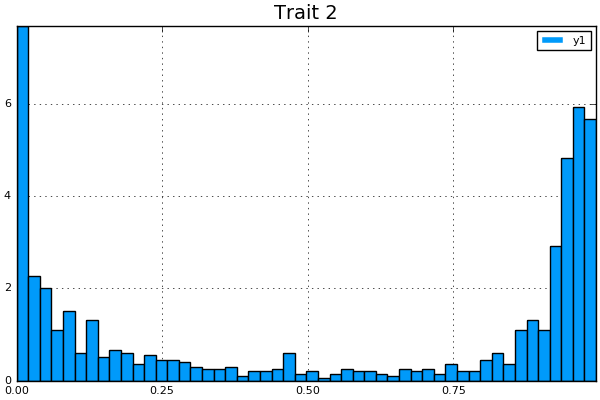

In [28]:
#heritability for trait 2
report(samples4h2,index=2)

In [ ]:
#genetic correlation between trait 1 and trait 2
report2(reformat(samples4G),index=[1,2]);

<div class="span5 alert alert-info">
 <font size="5" face="Georgia">II. Multiple Traits Analyses with Marker Effects and Polygenic Effects</font><br> 
</div>

<button type="button" class="btn btn-lg btn-primary">Build Model</button> 

In [23]:
model_equations = "BW = intercept + age + sex + Animal;
                   CW = intercept + age + sex + Animal";
model2          = build_model(model_equations,R);

set_covariate(model2,"age");

get pedigree information from a file

In [24]:
ped=get_pedigree(pedfile);

Finished!


In [25]:
GA = G*0.1
set_random(model2,"Animal",ped,GA)

In [26]:
GM = G*0.9
add_markers(model2,genofile,GM,separator=',',header=true);

5 markers on 4 individuals were added.


<button type="button" class="btn btn-lg btn-primary">Run Model</button> 

In [27]:
Pi=Dict([1.0; 1.0]=>0.25,[1.0;0.0]=>0.25,[0.0,1.0]=>0.25,[0.0; 0.0]=>0.25)
out2=runMCMC(model2,data,Pi=Pi,chain_length=5000,methods="BayesC");

Priors for marker effects covariance matrix were calculated from genetic covariance matrix and π.
Marker effects covariance matrix is 
[15.780822 1.578082
 1.578082 1.578082].


MCMC Information:
methods                                      BayesC
chain_length                                   5000
estimatePi                                    false
constraint                                    false
missing_phenotypes                            false
starting_value                                false
output_samples_frequency                          0
printout_frequency                             5001
update_priors_frequency                           0

Degree of freedom for hyper-parameters:
residual variances:                           4.000
iid random effect variances:                  4.000
polygenic effect variances:                   4.000
marker effect variances:                      4.000



running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:01


<button type="button" class="btn btn-lg btn-primary">Check Results</button> 

In [28]:
keys(out2)

Base.KeyIterator for a Dict{Any,Any} with 6 entries. Keys:
  "Posterior mean of polygenic effects covariance matrix"
  "Model frequency"
  "Posterior mean of residual covariance matrix"
  "Posterior mean of marker effects"
  "Posterior mean of marker effects covariance matrix"
  "Posterior mean of location parameters"

In [29]:
out2["Posterior mean of polygenic effects covariance matrix"]

2x2 Array{Float64,2}:
 2.03556   0.109594
 0.109594  0.195886